In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
train_path='/content/drive/MyDrive/498ds/Training'

In [14]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [16]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.transform = transform
        classes = os.listdir(root_dir)
        for cls in classes:
            img_files = glob.glob(os.path.join(root_dir, cls, '*.jpg'))
            self.images.extend(img_files)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

dataset = BrainTumorDataset(train_path, transform)
dataloader = DataLoader(dataset, batch_size=64,num_workers=2,pin_memory=True, shuffle=True)


In [39]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),   # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),     # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),  # Output shape (batch,1,4,4)

        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1).mean(1)  # Average over spatial dims

# WGAN loss
def generator_loss(fake_scores):
    return -fake_scores.mean()

def discriminator_loss(real_scores, fake_scores):
    return fake_scores.mean() - real_scores.mean()



In [41]:
def compute_gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [42]:
nz = 100  # size of latent vector
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

In [43]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.9))


In [44]:
num_epochs = 200
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise).detach()

        real_scores = netD(real_images)
        fake_scores = netD(fake_images)
        gp = compute_gradient_penalty(netD, real_images, fake_images, device=device)

        d_loss = discriminator_loss(real_scores, fake_scores) + 10 * gp

        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        # Train Generator twice
        if i % 2 == 0:
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_scores = netD(fake_images)

            g_loss = generator_loss(fake_scores)

            optimizerG.zero_grad()
            g_loss.backward()
            optimizerG.step()

    print(f"Epoch {epoch}: D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

Epoch 0: D_loss: -23.0435, G_loss: 16.0372
Epoch 1: D_loss: -29.8489, G_loss: 18.2418
Epoch 2: D_loss: -39.5364, G_loss: 21.0765
Epoch 3: D_loss: -55.8522, G_loss: 30.6532
Epoch 4: D_loss: -65.6668, G_loss: 32.7344
Epoch 5: D_loss: -87.3103, G_loss: 42.5237
Epoch 6: D_loss: -88.8609, G_loss: 46.3650
Epoch 7: D_loss: -10.6402, G_loss: 31.9993
Epoch 8: D_loss: -35.8139, G_loss: 20.1155
Epoch 9: D_loss: -35.8372, G_loss: 21.2348
Epoch 10: D_loss: -86.9516, G_loss: 26.8955
Epoch 11: D_loss: -60.6019, G_loss: 24.0595
Epoch 12: D_loss: -78.9229, G_loss: 35.9867
Epoch 13: D_loss: -49.8997, G_loss: 33.6548
Epoch 14: D_loss: -120.0171, G_loss: 38.2626
Epoch 15: D_loss: -94.5779, G_loss: 31.9934
Epoch 16: D_loss: -107.8838, G_loss: 36.9733
Epoch 17: D_loss: -106.6652, G_loss: 35.5754
Epoch 18: D_loss: -143.5743, G_loss: 39.7524
Epoch 19: D_loss: -122.7105, G_loss: 34.5087
Epoch 20: D_loss: -120.9763, G_loss: 34.0989
Epoch 21: D_loss: -43.6010, G_loss: 40.9328
Epoch 22: D_loss: -118.3522, G_loss:

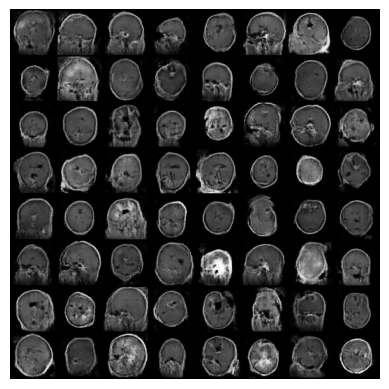

In [45]:
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, padding=2, normalize=True)
    plt.imshow(np.transpose(img_grid, (1,2,0)))
    plt.axis('off')
    plt.show()